In [51]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [52]:
data = pd.read_csv("sound_features.csv", index_col=0)
df = pd.DataFrame(data)
df.columns

Index(['zcr_mean', 'rms_mean', 'pitch_mean', 'emotion', 'intensity',
       'mfcc_mean1', 'mfcc_mean2', 'mfcc_mean3', 'mfcc_mean4', 'mfcc_mean5',
       'mfcc_mean6', 'mfcc_mean7', 'mfcc_mean8', 'mfcc_mean9', 'mfcc_mean10',
       'mfcc_mean11', 'mfcc_mean12', 'mfcc_mean13', 'mfcc_std1', 'mfcc_std2',
       'mfcc_std3', 'mfcc_std4', 'mfcc_std5', 'mfcc_std6', 'mfcc_std7',
       'mfcc_std8', 'mfcc_std9', 'mfcc_std10', 'mfcc_std11', 'mfcc_std12',
       'mfcc_std13', 'chroma_mean1', 'chroma_mean2', 'chroma_mean3',
       'chroma_mean4', 'chroma_mean5', 'chroma_mean6', 'chroma_mean7',
       'chroma_mean8', 'chroma_mean9', 'chroma_mean10', 'chroma_mean11',
       'chroma_mean12', 'spectral_contrast_mean1', 'spectral_contrast_mean2',
       'spectral_contrast_mean3', 'spectral_contrast_mean4',
       'spectral_contrast_mean5', 'spectral_contrast_mean6',
       'spectral_contrast_mean7', 'tonnetz_mean1', 'tonnetz_mean2',
       'tonnetz_mean3', 'tonnetz_mean4', 'tonnetz_mean5', 'tonnetz_mea

In [53]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)),int(0.8*len(df))])
print(train.shape)
print(test.shape)
print(valid.shape)

(864, 56)
(288, 56)
(288, 56)


C:\Users\callu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [54]:
def scale_set(data, oversample):
    feature_cols = [i for i in range(data.shape[1])if i != 3]
    x = data.iloc[:, feature_cols].values
    y = data.iloc[:, 3].values
    
    scalar = StandardScaler()
    x = scalar.fit_transform(x)

    if oversample:
        ros = RandomOverSampler()
        x,y = ros.fit_resample(x,y)
    
    data = np.hstack((x, np.reshape(y,(-1,1))))

    return data, x, y


In [55]:
train, X_train, y_train = scale_set(train, True)
valid, X_valid, y_valid = scale_set(valid, False)
test, X_test, y_test = scale_set(test, False)
y_train -= 1
y_test -= 1
print(np.unique(y_train))

[0 1 2 3 4 5 6 7]


Random Forest Model

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [57]:
RFC_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42
    )
RFC_model = RFC_model.fit(X_train, y_train)

In [58]:
y_pred = RFC_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.48      0.53      0.50        19
           1       0.52      0.82      0.64        39
           2       0.44      0.45      0.45        33
           3       0.73      0.30      0.42        37
           4       0.74      0.59      0.66        49
           5       0.45      0.34      0.39        38
           6       0.38      0.37      0.38        41
           7       0.40      0.62      0.49        32

    accuracy                           0.50       288
   macro avg       0.52      0.50      0.49       288
weighted avg       0.53      0.50      0.50       288



XGBoost

In [59]:
from xgboost import XGBClassifier

In [60]:
XGBC_model = XGBClassifier(
    n_estimators = 200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

In [61]:
XGBC_model.fit(X_train, y_train)

C:\Users\callu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [16:15:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [62]:
y_pred = XGBC_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.42      0.43        19
           1       0.61      0.79      0.69        39
           2       0.38      0.52      0.44        33
           3       0.48      0.27      0.34        37
           4       0.77      0.69      0.73        49
           5       0.40      0.37      0.38        38
           6       0.46      0.39      0.42        41
           7       0.51      0.62      0.56        32

    accuracy                           0.52       288
   macro avg       0.51      0.51      0.50       288
weighted avg       0.52      0.52      0.51       288



In [63]:
import tensorflow

In [64]:
y_train_cat = tensorflow.keras.utils.to_categorical(y_train, num_classes=8)  
y_test_cat = tensorflow.keras.utils.to_categorical(y_test, num_classes=8)
y_valid -= 1
y_valid_cat = tensorflow.keras.utils.to_categorical(y_valid, num_classes=8)

In [65]:
nn_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(64, activation="relu"),
    tensorflow.keras.layers.Dropout(0.3),
    tensorflow.keras.layers.Dense(64, activation="relu"),
    tensorflow.keras.layers.Dropout(0.3),
    tensorflow.keras.layers.Dense(8,activation="softmax")
])

In [66]:
nn_model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss='categorical_crossentropy')

In [67]:
print(X_train.shape[0])
y_train_cat.shape[0]

968


968

In [68]:
history = nn_model.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_data=(X_valid, y_valid_cat),
    verbose=1,
)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.2161 - val_loss: 2.0101
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0251 - val_loss: 1.9141
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9005 - val_loss: 1.8459
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7956 - val_loss: 1.7775
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7630 - val_loss: 1.7132
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6486 - val_loss: 1.6587
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6252 - val_loss: 1.6080
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5849 - val_loss: 1.5742
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5007 - val_loss: 1.5300
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4968 - val_loss: 1.4986
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4254 - val_loss: 1.4633
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3972 - va

In [69]:
def plot_history(history):

    plt.plot(history.history["loss"], label = "loss")
    plt.plot(history.history["val_loss"], label = "val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Binary crossentropy")
    plt.legend()
    plt.grid(True)

    plt.show()

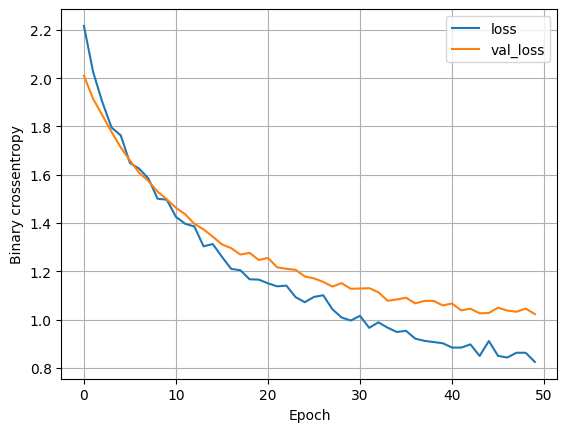

In [70]:
plot_history(history)

In [71]:
y_pred = nn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [72]:
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.44      0.42      0.43        19
           1       0.64      0.69      0.67        39
           2       0.45      0.45      0.45        33
           3       0.59      0.46      0.52        37
           4       0.74      0.76      0.75        49
           5       0.61      0.53      0.56        38
           6       0.54      0.54      0.54        41
           7       0.50      0.66      0.57        32

    accuracy                           0.58       288
   macro avg       0.56      0.56      0.56       288
weighted avg       0.58      0.58      0.58       288



In [73]:
import joblib

In [74]:
joblib.dump(XGBC_model, 'XGBC_emotion_model.joblib')
joblib.dump(RFC_model, 'RFC_emotion_model.joblib')
nn_model.save("nn_emotion_model.keras")

In [75]:
print(tensorflow.__version__)

2.20.0
